In [12]:

import ast
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit

## 1. CHECKING IF THE DATA IS INTUITIVE
- Independent Features:

        - date​: Date when forecast issued in yyyyMMddHH format 
        - hors​: Lead time (in hours) of forecast 
        - u​: Forecasted zonal wind component 
        - v​: Forecasted meridional wind component 
        - ws​: Forecasted wind speed 
        - wd​: Forecasted wind direction

Target Features: 
wp1-wp7​: Normalized wind power measurements (0-1) for the 7 wind farms

In [2]:
train_data_path = "GEF2012-wind-forecasting/train.csv"
windforecasts_data_paths = {f"wp{i}": f"GEF2012-wind-forecasting/windforecasts_wf{i}.csv" for i in range(1, 8)}

In [3]:
train_df = pd.read_csv(train_data_path)
train_df.head()

,date,wp1,wp2,wp3,wp4,wp5,wp6,wp7
0,2009070100,0.045,0.233,0.494,0.105,0.056,0.118,0.051
1,2009070101,0.085,0.249,0.257,0.105,0.066,0.066,0.051
2,2009070102,0.020,0.175,0.178,0.033,0.015,0.026,0.000
3,2009070103,0.060,0.085,0.109,0.022,0.010,0.013,0.000
4,2009070104,0.045,0.032,0.079,0.039,0.010,0.000,0.000


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18757 entries, 0 to 18756
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    18757 non-null  int64  
 1   wp1     18757 non-null  float64
 2   wp2     18757 non-null  float64
 3   wp3     18757 non-null  float64
 4   wp4     18757 non-null  float64
 5   wp5     18757 non-null  float64
 6   wp6     18757 non-null  float64
 7   wp7     18757 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 1.1 MB


In [5]:
train_df.describe()

,date,wp1,wp2,wp3,wp4,wp5,wp6,wp7
count,1.875700e+04,18757.000000,18757.000000,18757.000000,18757.000000,18757.000000,18757.000000,18757.000000
mean,2.010231e+09,0.252388,0.265983,0.334571,0.286173,0.272584,0.286774,0.290542
std,8.803362e+05,0.246381,0.273205,0.318636,0.295069,0.294221,0.283023,0.305272
min,2.009070e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.010011e+09,0.050000,0.042000,0.069000,0.022000,0.040000,0.053000,0.025000
50%,2.010073e+09,0.175000,0.164000,0.217000,0.182000,0.157000,0.184000,0.177000
75%,2.011033e+09,0.381000,0.423000,0.563000,0.474000,0.415000,0.461000,0.505000
max,2.012063e+09,0.947000,0.989000,0.978000,0.992000,0.966000,0.974000,0.960000


In [6]:
# Convert 'date' to datetime format='%Y-%m-%d'
train_df["date"] = pd.to_datetime(train_df["date"], format="%Y%m%d%H")
train_df.head(2)

,date,wp1,wp2,wp3,wp4,wp5,wp6,wp7
0,2009-07-01 00:00:00,0.045,0.233,0.494,0.105,0.056,0.118,0.051
1,2009-07-01 01:00:00,0.085,0.249,0.257,0.105,0.066,0.066,0.051


In [7]:
wf1_df = pd.read_csv(windforecasts_data_paths["wp1"])
wf1_df.head(10)

,date,hors,u,v,ws,wd
0,2009070100,1,2.34,-0.79,2.47,108.68
1,2009070100,2,2.18,-0.99,2.40,114.31
2,2009070100,3,2.20,-1.21,2.51,118.71
3,2009070100,4,2.35,-1.40,2.73,120.86
4,2009070100,5,2.53,-1.47,2.93,120.13
5,2009070100,6,2.66,-1.29,2.96,115.79
6,2009070100,7,2.69,-0.81,2.81,106.71
7,2009070100,8,2.72,-0.26,2.73,95.39
8,2009070100,9,2.87,0.08,2.87,88.50
9,2009070100,10,3.23,-0.01,3.23,90.19


In [8]:
wf1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104832 entries, 0 to 104831
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    104832 non-null  int64  
 1   hors    104832 non-null  int64  
 2   u       93672 non-null   float64
 3   v       93672 non-null   float64
 4   ws      93672 non-null   float64
 5   wd      93672 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 4.8 MB


In [9]:
wf1_df.describe()

,date,hors,u,v,ws,wd
count,1.048320e+05,104832.000000,93672.000000,93672.00000,93672.000000,93672.000000
mean,2.010559e+09,24.500000,1.598712,-0.09969,4.072487,144.814262
std,9.402333e+05,13.853465,3.052834,2.87600,1.889861,93.518468
min,2.009070e+09,1.000000,-9.240000,-10.85000,0.010000,0.020000
25%,2.010033e+09,12.750000,-0.430000,-2.23000,2.750000,72.920000
50%,2.010123e+09,24.500000,1.890000,-0.17000,3.680000,122.630000
75%,2.011093e+09,36.250000,3.530000,2.06000,5.110000,197.180000
max,2.012063e+09,48.000000,15.250000,10.71000,15.810000,359.990000


In [10]:
def update_date_forecasted(date, hours):
    date_str = str(int(date)) 
    
    hours = int(date_str[8:])+hours
    

    if hours >= 24:
        dt_str = f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:8]} {date_str[8:]}"

        date = datetime.strptime(dt_str, "%Y-%m-%d %H")

        delta_obj = timedelta(hours=hours)

        # Convert back to datetime object
        dt_obj = datetime(date.year, date.month, date.day, 0, 0, 0) + delta_obj

    else:
    
    # Convert to datetime object
        hours = str(int(hours))
        dt_str = f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:8]} {hours.zfill(2)}:00:00"
        dt_obj = datetime.strptime(dt_str, '%Y-%m-%d %H:%M:%S')

    return dt_obj

In [11]:
# To better understand windforecasts wf1 - wf7, let's first add another column `date_forecasted` that is the date where the values are forecasted for

wf1_df["date_forecasted"] = wf1_df.apply(
    lambda row: update_date_forecasted(row.date, row.hors), axis=1
)
wf1_df.head(2)


,date,hors,u,v,ws,wd,date_forecasted
0,2009070100,1,2.34,-0.79,2.47,108.68,2009-07-01 01:00:00
1,2009070100,2,2.18,-0.99,2.40,114.31,2009-07-01 02:00:00


In [12]:
# Get the number of forecasts made for a datetime
train_df["forecast_count"] = train_df.date.map(wf1_df.groupby("date_forecasted").size())
train_df.head(2)


,date,wp1,wp2,wp3,wp4,wp5,wp6,wp7,forecast_count
0,2009-07-01 00:00:00,0.045,0.233,0.494,0.105,0.056,0.118,0.051,NaN
1,2009-07-01 01:00:00,0.085,0.249,0.257,0.105,0.066,0.066,0.051,1.0


In [13]:
train_df.describe()

,wp1,wp2,wp3,wp4,wp5,wp6,wp7,forecast_count
count,18757.000000,18757.000000,18757.000000,18757.000000,18757.000000,18757.000000,18757.000000,18756.000000
mean,0.252388,0.265983,0.334571,0.286173,0.272584,0.286774,0.290542,3.996161
std,0.246381,0.273205,0.318636,0.295069,0.294221,0.283023,0.305272,0.094567
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.050000,0.042000,0.069000,0.022000,0.040000,0.053000,0.025000,4.000000
50%,0.175000,0.164000,0.217000,0.182000,0.157000,0.184000,0.177000,4.000000
75%,0.381000,0.423000,0.563000,0.474000,0.415000,0.461000,0.505000,4.000000
max,0.947000,0.989000,0.978000,0.992000,0.966000,0.974000,0.960000,4.000000


In [14]:
# Extract unique values from forecast_count
forecast_counts = train_df.forecast_count.unique()
print(np.isnan(forecast_counts[0]))
print(type(forecast_counts[0]))

True
<class 'numpy.float64'>


In [15]:
 #Get start end dates of all the above forecasts counts
for count in forecast_counts:
    if np.isnan(count):
        train_df_filtered = train_df[train_df["forecast_count"].isnull()]
    else:
        train_df_filtered = train_df[train_df["forecast_count"] == count]
    start_date, end_date = train_df_filtered.date.min(), train_df_filtered.date.max()
    print(f"{count}: total: {len(train_df_filtered)}")
    print(f"{start_date} to {end_date}")

nan: total: 1
2009-07-01 00:00:00 to 2009-07-01 00:00:00
1.0: total: 12
2009-07-01 01:00:00 to 2009-07-01 12:00:00
2.0: total: 12
2009-07-01 13:00:00 to 2009-07-02 00:00:00
3.0: total: 12
2009-07-02 01:00:00 to 2009-07-02 12:00:00
4.0: total: 18720
2009-07-02 13:00:00 to 2012-06-26 12:00:00


In [16]:
date_use = train_df[train_df["forecast_count"] == 4].at[37, "date"]
wf1_df_filtered = wf1_df[wf1_df["date_forecasted"] == date_use]
wf1_df_filtered.head()

,date,hors,u,v,ws,wd,date_forecasted
36,2009070100,37,-0.57,-1.66,1.76,198.89,2009-07-02 13:00:00
72,2009070112,25,-1.16,-0.88,1.46,232.75,2009-07-02 13:00:00
108,2009070200,13,-0.30,-1.48,1.51,191.55,2009-07-02 13:00:00
144,2009070212,1,0.39,-2.18,2.22,169.75,2009-07-02 13:00:00


| S/N | Findings | Actions to be taken |
|:---:|:---:|:---:|
| 1 | Due to the fact that wp1 to wp7 belongs to 7 different wind farms, which means that there are several other factors affecting power generated (e.g. type of generator) | verify feasibility. create a new feature 'farm_no' |
| 2 | There are 0-4 forecasts for any specific time, the accuracy of the forecast might differ which calls for different weights. | verify the accuracy of the forecasts. drop the 0 forecasts and take the mean of the forecasts for now |
| 3 | For 'hor', lead time < 12 may not be useful (i.e. the company is unable to make useful decision with less than 12 hours lead) | verify the assumption. use all data for now |
| 4 | For 'date', we might be able to feature engineer more useful features (e.g. to reflect seasonality, cyclical) | univariate analysis |
| 5 | In order to reduce noise from windforecasts, we might be able to use moving average to reflect the general trend instead of just 'u', 'v', 'ws', 'wd' | univariate analysis |
| 6 | For 'wd' it seems to be 0-360 degrees, can convert into values that better reflect it's effect on wind turbine (e.g. cyclical) | univariate analysis |
| 7 | Lack of knowledge of 'u' and 'v'  | More research are needed to clarify what are these two factor works |

In [17]:
# Based on the above findings, some simple data cleaning/ engineering are done here to make further analysis easier

# 0) Drop the 0 forecast and remove `forecast_count` column
train_df_1 = train_df[train_df["forecast_count"].notnull()].drop(
    ["forecast_count"], axis=1
)

# 1) Create a new feature 'farm_no'
train_df_2 = pd.melt(
    train_df_1,
    id_vars=["date"],
    value_vars=["wp1", "wp2", "wp3", "wp4", "wp5", "wp6", "wp7"],
    var_name="wind_farm",
    value_name="power",
)

# 2) Take the mean of all the forecasts and combine all wf1-wf7
wf_df = None
for wf, data_path in windforecasts_data_paths.items():
    temp_wf_df = pd.read_csv(data_path)
    temp_wf_df["date_forecasted"] = temp_wf_df.apply(
        lambda row: update_date_forecasted(row.date, row.hors), axis=1
    )
    temp_wf_df = (
        temp_wf_df.drop(["date", "hors"], axis=1)
        .groupby(["date_forecasted"], as_index=False)
        .mean()
    )
    temp_wf_df = temp_wf_df.rename(columns={"date_forecasted": "date"})
    temp_wf_df["wind_farm"] = wf

    if wf_df is None:
        wf_df = temp_wf_df
    else:
        wf_df = pd.concat([wf_df, temp_wf_df])

# 3) Combine train_df and wf1-wf7 into one dataset
combined_df = train_df_2.merge(wf_df, how="left", on=["date", "wind_farm"])

combined_df.head()

# Do some further checks: combined_df.info(), combined_df.describe(), combined_df.isnull().sum()
combined_df.to_csv('./combined.csv', index=False)

## UNIVARIATE ANALYSIS
For our dataset, we can categorise into 3 main categories for our analysis: 
- Numerical: feature that contains numeric values 
- Categorical: feature that contains categories 
- Time_Date: feature that contains time/date

For this section we will: 
- conduct relevant analysis based on the category 
- conduct feature cleaning and engineering based on findings from part 1 and part 2a (if required)


### NUMERICAL FEATURES: 
'power', 'u', 'v', 'ws', 'wd'

In [6]:
combined_data_path = "./combined.csv"
combined_df = pd.read_csv(combined_data_path)

In [7]:
def plot_distribution(data, num_features):
    # Create a grid of subplots with 1 rows and n column
    fig, axs = plt.subplots(nrows= 1, ncols= len(num_features), figsize=(20, 4))
    a = 0
    for i in num_features:
        sns.boxplot(x= i, orient="h", data=data, ax=axs[a])
        axs[a].set_title(i)
        a += 1
    
    plt.show()

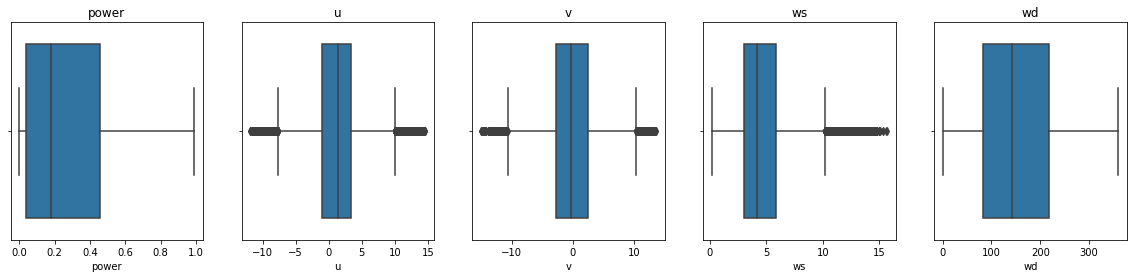

In [8]:
# Plot distribution of all numerical features for analysis
num_features = ["power", "u", "v", "ws", "wd"]
plot_distribution(
    combined_df,
    num_features,
)

| S/N | Findings | Actions to be taken |
|:---:|:---:|:---:|
| 1 | Due to the fact that wp1 to wp7 belongs to 7 different wind farms, which means that there are several other factors affecting power generated (e.g. type of generator) | verify feasibility. create a new feature 'farm_no' |
| 2 | There are 0-4 forecasts for any specific time, the accuracy of the forecast might differ which calls for different weights. | verify the accuracy of the forecasts. drop the 0 forecasts and take the mean of the forecasts for now |
| 3 | For 'hor', lead time < 12 may not be useful (i.e. the company is unable to make useful decision with less than 12 hours lead) | verify the assumption. use all data for now |
| 4 | For 'date', we might be able to feature engineer more useful features (e.g. to reflect seasonality, cyclical) | univariate analysis |
| 5 | In order to reduce noise from windforecasts, we might be able to use moving average to reflect the general trend instead of just 'u', 'v', 'ws', 'wd' | univariate analysis |
| 6 | For 'wd' it seems to be 0-360 degrees, can convert into values that better reflect it's effect on wind turbine (e.g. cyclical) | univariate analysis |
| 7 | Lack of knowledge of 'u' and 'v'  | More research are needed to clarify what are these two factor works |

## Feature cleaning and engineering for numerical features

### Feature: 
'u', 'v', 'ws', 'wd'

In [9]:
combined_df.head()

,date,wind_farm,power,u,v,ws,wd
0,2009-07-01 01:00:00,wp1,0.085,2.34,-0.79,2.47,108.68
1,2009-07-01 02:00:00,wp1,0.020,2.18,-0.99,2.40,114.31
2,2009-07-01 03:00:00,wp1,0.060,2.20,-1.21,2.51,118.71
3,2009-07-01 04:00:00,wp1,0.045,2.35,-1.40,2.73,120.86
4,2009-07-01 05:00:00,wp1,0.035,2.53,-1.47,2.93,120.13


In [10]:
def rolling_average(data, feature_list):
    for i in feature_list:
        n = len(data[i])
        rolling_avg = []
        for j in range(n):
            if j == 0:
                avg = data[i][j]
                rolling_avg.append(avg)
            elif j == 1:
                avg = (data[i][0] + data[i][j]) / 2
                rolling_avg.append(avg)
            else:
                avg = (data[i][j] + data[i][j-1] + data[i][j-2]) / 3
                rolling_avg.append(avg)
    
        data[i] = rolling_avg
        suffix = '_avg'
        data = data.rename(columns={i: i + suffix})
    return data


In [11]:
# From 1 and from research, it is undesirable is wind forecasts fluctuates alot in a short time span
# Create new features for 'u', 'v', 'ws', 'wd' using (t-2, t-1, t)
# features = ["u", "v", "ws", "wd"]
combined_df = rolling_average(combined_df, ["u", "v", "ws", "wd"])
combined_df.head()

,date,wind_farm,power,u_avg,v_avg,ws_avg,wd_avg
0,2009-07-01 01:00:00,wp1,0.085,2.340000,-0.790000,2.470000,108.680
1,2009-07-01 02:00:00,wp1,0.020,2.260000,-0.890000,2.435000,111.495
2,2009-07-01 03:00:00,wp1,0.060,2.240000,-0.996667,2.460000,113.900
3,2009-07-01 04:00:00,wp1,0.045,2.243333,-1.200000,2.546667,117.960
4,2009-07-01 05:00:00,wp1,0.035,2.360000,-1.360000,2.723333,119.900


### Feature:
 'power'

### CATEGORICAL FEATURES: 
'wind_farm'

a) Analysis of categorical features - Countplot

In [4]:
cat_features = ["wind_farm"]
plot_distribution(
    combined_df,
    cat_features,
    cols=2,
)

NameError: name 'plot_distribution' is not defined

### DATE_TIME FEATURES: 
'date'

##### a) Analysis of datetime features - Duplicated Entries

In [14]:
# Duplicated analysis
combined_df.loc[combined_df.duplicated(subset=["date", "wind_farm"], keep=False)]

,date,wind_farm,power,u_avg,v_avg,ws_avg,wd_avg


Note: It is looking for duplicated rows in the dataframe based on the "date" and "wind_farm" columns, and keeping all duplicates (as indicated by the "keep=False" argument).

The resulting dataframe will only contain the duplicated rows, and can be used for further analysis or to remove the duplicates from the original dataframe.
It is important to note that the code does not actually modify the original dataframe, but rather creates a new dataframe containing only the duplicated rows. If the goal is to remove the duplicates from the original dataframe, the "drop_duplicates()" method can be used.


- According to the result, there is no duplicate one.

##### b) Feature cleaning and engineering for datetime features

#### Feature: 
'date'

In [15]:
def extract_datetime_features(data, date, new_feature):
    # convert the date column to a datetime object
    data[date] = pd.to_datetime(data[date]) 

    data[new_feature[0]] = data[date].dt.year
    data[new_feature[1]] = data[date].dt.month
    data[new_feature[2]] = data[date].dt.day
    data[new_feature[3]] = data[date].dt.hour

    # drop the original date column
    data = data.drop('date', axis=1)
    
    return data

In [16]:
# From 1 we might be able to feature engineer more useful features (e.g. to reflect seasonality, cyclical)
# Create 4 new features, 'year', 'month', 'day', 'hour' to replace 'date'
combined_df = extract_datetime_features(
    combined_df, "date", ["year", "month", "day", "hour"]
)
combined_df.head()

,wind_farm,power,u_avg,v_avg,ws_avg,wd_avg,year,month,day,hour
0,wp1,0.085,2.340000,-0.790000,2.470000,108.680,2009,7,1,1
1,wp1,0.020,2.260000,-0.890000,2.435000,111.495,2009,7,1,2
2,wp1,0.060,2.240000,-0.996667,2.460000,113.900,2009,7,1,3
3,wp1,0.045,2.243333,-1.200000,2.546667,117.960,2009,7,1,4
4,wp1,0.035,2.360000,-1.360000,2.723333,119.900,2009,7,1,5


### Feature: 
'month', 'day', 'hour'

In [17]:
def cyclical_features(data, feature_list):

    # create cyclical features for month, day, and hour
    data['month_sin'] = np.sin(2 * np.pi * data[feature_list[0]] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data[feature_list[0]] / 12)
    data['day_sin'] = np.sin(2 * np.pi * data[feature_list[1]] / 31)
    data['day_cos'] = np.cos(2 * np.pi * data[feature_list[1]] / 31)
    data['hour_sin'] = np.sin(2 * np.pi * data[feature_list[2]] / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data[feature_list[2]] / 24)

    return data

In [18]:
# Create cyclical features for 'month', 'day', 'hour'
combined_df = cyclical_features(combined_df, ["month", "day", "hour"])
combined_df.head()

,wind_farm,power,u_avg,v_avg,ws_avg,wd_avg,year,month,day,hour,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
0,wp1,0.085,2.340000,-0.790000,2.470000,108.680,2009,7,1,1,-0.5,-0.866025,0.201299,0.97953,0.258819,0.965926
1,wp1,0.020,2.260000,-0.890000,2.435000,111.495,2009,7,1,2,-0.5,-0.866025,0.201299,0.97953,0.500000,0.866025
2,wp1,0.060,2.240000,-0.996667,2.460000,113.900,2009,7,1,3,-0.5,-0.866025,0.201299,0.97953,0.707107,0.707107
3,wp1,0.045,2.243333,-1.200000,2.546667,117.960,2009,7,1,4,-0.5,-0.866025,0.201299,0.97953,0.866025,0.500000
4,wp1,0.035,2.360000,-1.360000,2.723333,119.900,2009,7,1,5,-0.5,-0.866025,0.201299,0.97953,0.965926,0.258819


In [19]:
combined_df[combined_df['day']==2]

,wind_farm,power,u_avg,v_avg,ws_avg,wd_avg,year,month,day,hour,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
23,wp1,0.000,1.333333,-1.110000,1.786667,132.915000,2009,7,2,0,-5.000000e-01,-0.866025,0.394356,0.918958,0.000000,1.000000
24,wp1,0.000,0.859444,-1.237222,1.565556,148.352778,2009,7,2,1,-5.000000e-01,-0.866025,0.394356,0.918958,0.258819,0.965926
25,wp1,0.010,0.411667,-1.330556,1.481111,164.773889,2009,7,2,2,-5.000000e-01,-0.866025,0.394356,0.918958,0.500000,0.866025
26,wp1,0.010,0.042222,-1.350000,1.454444,178.587778,2009,7,2,3,-5.000000e-01,-0.866025,0.394356,0.918958,0.707107,0.707107
27,wp1,0.000,-0.224444,-1.298889,1.400000,190.231111,2009,7,2,4,-5.000000e-01,-0.866025,0.394356,0.918958,0.866025,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130411,wp7,0.328,2.663333,-4.739167,5.451667,150.385000,2012,4,2,20,8.660254e-01,-0.500000,0.394356,0.918958,-0.866025,0.500000
130412,wp7,0.227,2.359167,-5.110833,5.666667,154.998333,2012,4,2,21,8.660254e-01,-0.500000,0.394356,0.918958,-0.707107,0.707107
130413,wp7,0.227,1.665000,-5.221667,5.540000,162.394167,2012,4,2,22,8.660254e-01,-0.500000,0.394356,0.918958,-0.500000,0.866025
130414,wp7,0.076,0.758333,-5.028333,5.168333,171.982500,2012,4,2,23,8.660254e-01,-0.500000,0.394356,0.918958,-0.258819,0.965926


### 3) EXPLORE HIDDEN RELATIONSHIPS BETWEEN FEATURES
For our dataset, we can categorise into 2 main categories for our analysis: 
Independent features 
Target features

For this section we will: 
- a) conduct correlation analysis amongst all features 
- b) plot graphs between Independent features and Target features to identify hidden relationships

#### a) Correlation analysis - Heatmap

In [20]:
# Split into independent features X and target features y
target_features = ["power"]
X = combined_df.drop(target_features, axis=1)
y = combined_df.loc[:, target_features]

<AxesSubplot:>

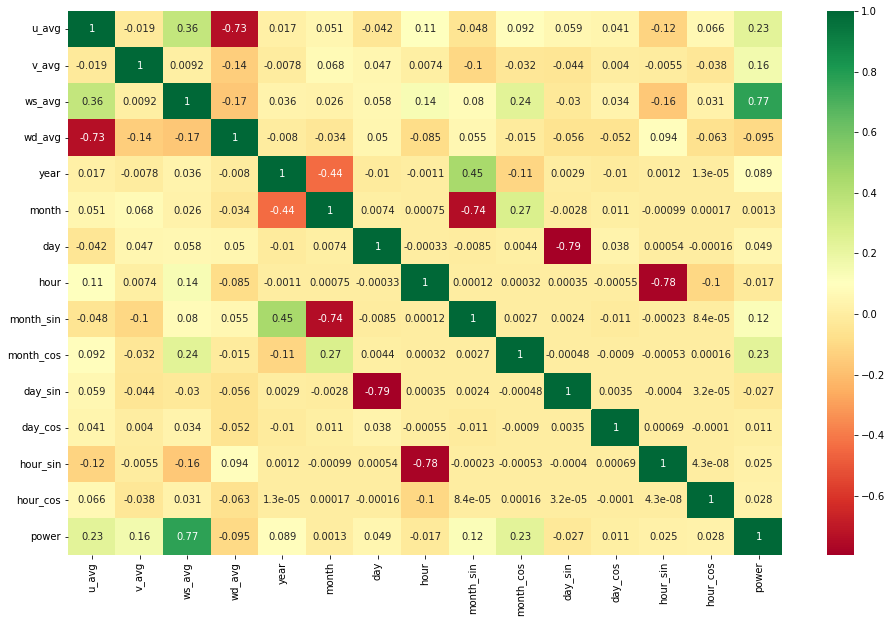

In [23]:
# Conduct correlation analysis for numerical features
all_features = pd.concat([X, y], axis=1)

# Plot heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(all_features.corr(), annot=True, cmap="RdYlGn")

| S/N | Findings | Actions to be taken |
|:---:|---|:---:|
| 1 | Extracting cyclical of some independent features does improve it's correlation with target feature (e.g. month vs month_sin, month_cos) | to remove the original features 'month', 'day', 'hour', 'wd_ravg' |
| 2 | Correlation between certain independent features seems to be high (e.g. wd_sin, u_ravg),should have multicollinearity issue | bivariate analysis |

In [25]:
# Drop the features replaced by cyclical features
headers_to_drop = ["month", "day", "hour", "wd_avg"]
combined_df = combined_df.drop(headers_to_drop, axis=1)

<AxesSubplot:>

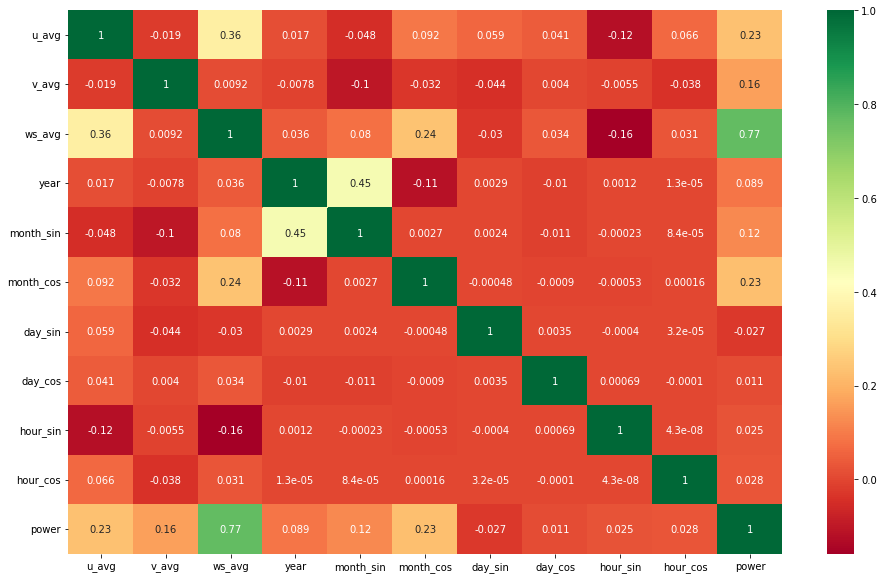

In [26]:
# Re-plot heatmap
# Split into independent features X and target features y
target_features = ["power"]
X = combined_df.drop(target_features, axis=1)
y = combined_df.loc[:, target_features]

# Conduct correlation analysis for numerical features
all_features = pd.concat([X, y], axis=1)

# Plot heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(all_features.corr(), annot=True, cmap="RdYlGn")

### b) Identify hidden relationships between independent variables - Scatterplot (numerical), Boxplot (categorical)

In [28]:
combined_df

,wind_farm,power,u_avg,v_avg,ws_avg,year,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
0,wp1,0.085,2.340000,-0.790000,2.470000,2009,-5.000000e-01,-0.866025,0.201299,0.979530,2.588190e-01,0.965926
1,wp1,0.020,2.260000,-0.890000,2.435000,2009,-5.000000e-01,-0.866025,0.201299,0.979530,5.000000e-01,0.866025
2,wp1,0.060,2.240000,-0.996667,2.460000,2009,-5.000000e-01,-0.866025,0.201299,0.979530,7.071068e-01,0.707107
3,wp1,0.045,2.243333,-1.200000,2.546667,2009,-5.000000e-01,-0.866025,0.201299,0.979530,8.660254e-01,0.500000
4,wp1,0.035,2.360000,-1.360000,2.723333,2009,-5.000000e-01,-0.866025,0.201299,0.979530,9.659258e-01,0.258819
...,...,...,...,...,...,...,...,...,...,...,...,...
131287,wp7,0.101,1.353333,-4.088333,4.322500,2012,1.224647e-16,-1.000000,-0.848644,0.528964,8.660254e-01,-0.500000
131288,wp7,0.076,1.177500,-4.375833,4.548333,2012,1.224647e-16,-1.000000,-0.848644,0.528964,7.071068e-01,-0.707107
131289,wp7,0.076,0.958333,-4.616667,4.730000,2012,1.224647e-16,-1.000000,-0.848644,0.528964,5.000000e-01,-0.866025
131290,wp7,0.076,0.775000,-4.699167,4.785000,2012,1.224647e-16,-1.000000,-0.848644,0.528964,2.588190e-01,-0.965926


In [29]:
# Drop the 'year' feature
combined_df = combined_df.drop(["year"], axis=1)

combined_df.head()

combined_df.to_csv('./cleaned.csv', index=False)

| Features | Analysis and Actions Taken |
|:---:|---|
|  | **NUMERICAL FEATURES** |
| 'power' | no actions taken |
| 'u' | replaced with rolling avg(t-2, t-1, t) |
| 'v' | replaced with rolling avg(t-2, t-1, t) |
| 'ws' | replaced with rolling avg(t-2, t-1, t) |
| 'wd' | replaced with rolling avg(t-2, t-1, t) and replace with cyclical feature |
|  | **CATEGORICAL FEATURES** |
| 'wind_farm' | created to represent the respective wind farms |
|  | **TIME_DATE FEATURES** |
| 'date' | replaced with cyclical features of 'month', 'day' and 'hour' |

### OBJECTIVE
Carries on from the eda above. We will preprocess and train models based on configurations supplied and present its findings of the analysis at the end.

#### GENERAL OVERVIEW OF MODEL TRAINING
- 1) PREPROCESS DATA:
        - Encode categorical features and scale the data

- 2) TRAIN TEST SPLIT:
        - Split the data into train and test set

- 3) MODEL TRAINING/SELECTION AND TUNING: 
        - Compare a few model's performance using grid search cross validation

In [50]:
data_path = "./cleaned.csv"
dataset = pd.read_csv(data_path)
dataset.head()


,wind_farm,power,u_avg,v_avg,ws_avg,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
0,wp1,0.085,2.340000,-0.790000,2.470000,-0.5,-0.866025,0.201299,0.97953,0.258819,0.965926
1,wp1,0.020,2.260000,-0.890000,2.435000,-0.5,-0.866025,0.201299,0.97953,0.500000,0.866025
2,wp1,0.060,2.240000,-0.996667,2.460000,-0.5,-0.866025,0.201299,0.97953,0.707107,0.707107
3,wp1,0.045,2.243333,-1.200000,2.546667,-0.5,-0.866025,0.201299,0.97953,0.866025,0.500000
4,wp1,0.035,2.360000,-1.360000,2.723333,-0.5,-0.866025,0.201299,0.97953,0.965926,0.258819


- 1) PREPROCESS DATA
Encode categorical features and scale the data

In [51]:
# Encode categorical feature: 'wind_farm'
# Extract the wind direction column from dataset
wind_farms = dataset["wind_farm"]

# Reshape the column to a 2D array
wind_farms_array = wind_farms.values.reshape(-1, 1)

# Perform one-hot encoding
encoder = OneHotEncoder()
wind_farms_encoded = encoder.fit_transform(wind_farms_array)

# Convert the encoded features to a pandas DataFrame
wind_farms_encoded_df = pd.DataFrame.sparse.from_spmatrix(wind_farms_encoded, columns=encoder.get_feature_names())

# Concatenate the one-hot encoded wind direction features with dataset
dataset_encoded = pd.concat([dataset, wind_farms_encoded_df], axis=1)

In [52]:
print(f"Data size after encoded: {len(dataset_encoded)}")
print(f"Data size before encoded: {len(dataset)}")

Data size after encoded: 131292
Data size before encoded: 131292


Data size should be the same after encoded.

- 2) TRAIN TEST SPLIT
Split the data into train and test set

In [80]:
# Train test split, stratify by wind_farm


# Split the data into train and test sets (80/20 split)
X_trainval, X_test, y_trainval, y_test = train_test_split(dataset_encoded.drop("power", axis=1), dataset_encoded["power"], test_size=0.2, random_state=42, stratify=dataset_encoded["wind_farm"])

# Split the train set into train and validation sets (75/25 split)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=X_trainval["wind_farm"])


In [81]:
# Drop wind_fram after split
X_train = X_train.drop('wind_farm', axis = 1)
X_test = X_test.drop('wind_farm', axis = 1)
X_val = X_val.drop('wind_farm', axis = 1)

In [83]:
import torch
from torch.utils.data import Dataset, DataLoader

class WindDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
# Load your data as PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
X_val = torch.tensor(X_val.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.long)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.long)

# Create a TensorDataset for each dataset
train_dataset = WindDataset(X_train, y_train)
val_dataset = WindDataset(X_val, y_val)
test_dataset = WindDataset(X_test, y_test)

# Create DataLoader objects for each dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

<ipython-input-83-f49f57cda157>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
<ipython-input-83-f49f57cda157>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)


 - network architecture 
 
We then define the WindForecastingModel class with one hidden layer as described earlier.

We set the hyperparameters for training including the learning rate and the number of epochs. We then create an instance of the model and define the loss function and optimizer. In this case, we use the mean squared error loss function and the stochastic gradient descent optimizer.

We then loop over the specified number of epochs and perform the forward pass, compute the loss, perform the backward pass, and update the weights of the model using the optimizer. We also print the loss value every 100 epochs to track the training progress.

Note that this is a basic example of how to train a PyTorch model for wind forecasting and you may need to adjust the hyperparameters and other aspects of the model architecture depending on your specific use case.

Epoch [1/10], Train Loss: 0.0016, Val Loss: 0.0005
Epoch [2/10], Train Loss: 0.0004, Val Loss: 0.0003
Epoch [3/10], Train Loss: 0.0003, Val Loss: 0.0002
Epoch [4/10], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [5/10], Train Loss: 0.0001, Val Loss: 0.0001
Epoch [6/10], Train Loss: 0.0001, Val Loss: 0.0001
Epoch [7/10], Train Loss: 0.0001, Val Loss: 0.0001
Epoch [8/10], Train Loss: 0.0001, Val Loss: 0.0001
Epoch [9/10], Train Loss: 0.0001, Val Loss: 0.0001
Epoch [10/10], Train Loss: 0.0001, Val Loss: 0.0001


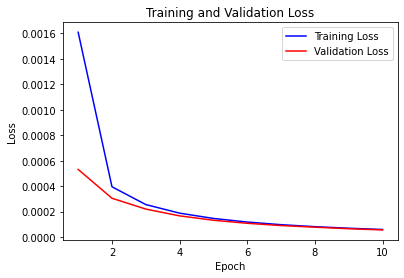

In [92]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define lists to store the training and validation loss for each epoch
train_losses = []
val_losses = []

# Define the model architecture
class WindForecastingModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(WindForecastingModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Set the hyperparameters for training
input_size = 16
hidden_size = 64
learning_rate = 0.01
num_epochs = 10

# Create an instance of the model
model = WindForecastingModel(input_size, hidden_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)


# Train the model
for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()
    train_loss = 0.0
    
    # Loop over the training set
    for i, (inputs, targets) in enumerate(train_loader):
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets.view(-1, 1))
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Accumulate the training loss
        train_loss += loss.item()
        
    # Calculate the average training loss for the epoch
    train_loss /= len(train_loader)
    
    # Evaluate the model on the validation set
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets.view(-1, 1))
            val_loss += loss.item()
            
        # Calculate the average validation loss for the epoch
        val_loss /= len(val_loader)
        
    # Print the training and validation loss for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Plot the training and validation loss for each epoch
plt.plot(range(1, epoch+2), train_losses, 'b', label='Training Loss')
plt.plot(range(1, epoch+2), val_losses, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()